In [0]:
!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo

Cloning into 'bert_repo'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 300.28 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 3.5MB/s 


In [0]:
!pip install simplerepresentations

     |████████████████████████████████| 501kB 6.6MB/s 
     |████████████████████████████████| 3.7MB 49.1MB/s 
     |████████████████████████████████| 1.0MB 36.8MB/s 
     |████████████████████████████████| 870kB 50.4MB/s 
  Created wheel for simplerepresentations: filename=simplerepresentations-0.0.4-cp36-none-any.whl size=8439 sha256=89c3c847af38803285feea2865d25759914ac18d17243096d734f030056af3d0
  Stored in directory: /root/.cache/pip/wheels/ab/cd/ab/6ba46ab4845442abb114bf92136a0d760151de2ccfb3af4d7d
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=829ac34b7e9405c38b50ee3b2cc542d8cd6585b59d8dd583fe638c8935473dc5
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built simplerepresentations sacremoses


In [0]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import spacy
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
%matplotlib inline
import numpy as np
# from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
from __future__ import absolute_import, division

import os
import time
import numpy as np
import pandas as pd
import gensim
from tqdm import tqdm
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

import sys
from os.path import dirname
#sys.path.append(dirname(dirname(__file__)))
from keras import initializers
from keras.engine import InputSpec, Layer
from keras import backend as K

import spacy

# Initialize session
sess = tf.Session()




In [0]:
from keras import backend as K
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 140
import pandas as pd
import numpy as np

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
def plt_dynamic(epoch):
    fig,ax = plt.subplots(1,1)
    x = list(range(1,epoch+1))

    vy = history.history['val_loss']
    ty = history.history['loss']
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
from sklearn.metrics import f1_score

In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv').fillna(' ')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv').fillna(' ')
original=pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP Original.csv")

In [0]:
from keras.layers import Layer

class BertLayer(Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_path,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "pooled_output"
        ]
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
# Build model
def build_model(max_seq_length): 
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3)(bert_inputs)
    dense = Dense(256, activation='relu')(bert_output)
    pred = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
from sklearn.model_selection import train_test_split

class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

def convert_text_to_examples_test(texts):
  InputExamples = []
  for text in texts:
    InputExamples.append(InputExample(guid=None, text_a=" ".join(text), text_b=None))
    
  return InputExamples
def convert_examples_to_features_test(tokenizer, examples, max_seq_length=160):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids = [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
           )

In [0]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


NameError: ignored

In [0]:
train_text, test_text, train_label, test_label = train_test_split( train['text'], train['target'], test_size=0.20, random_state=42)

In [0]:
# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels
 ) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [0]:
test_submission_examples=convert_text_to_examples_test(test['text'])
(test_input_ids_submisson, test_input_masks_submisson, test_segment_ids_submisson
) = convert_examples_to_features_test(tokenizer, test_submission_examples, max_seq_length=max_seq_length)

In [0]:
test_submission_examples.shape

NameError: ignored

In [0]:
in_id = Input(shape=(max_seq_length,), name="input_ids")
in_mask = Input(shape=(max_seq_length,), name="input_masks")
in_segment = Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]
bert_output = BertLayer(n_fine_tune_layers=2)(bert_inputs)
dense = Dense(256, activation='relu')(bert_output)
pred = Dense(1, activation='sigmoid')(dense)
    
model = Model(inputs=bert_inputs, outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 140)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
bert_layer_5 (BertLayer)        ((None, 140), 768)   110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
# test_labels=original['target']

In [0]:
history=model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=20,
    batch_size=128 )

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 47s 8ms/step - loss: 0.7858 - f1: 0.3571 - val_loss: 0.6400 - val_f1: 0.6190
Epoch 2/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6372 - f1: 0.5142 - val_loss: 0.6222 - val_f1: 0.5905
Epoch 3/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6212 - f1: 0.5621 - val_loss: 0.6072 - val_f1: 0.5735
Epoch 4/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6243 - f1: 0.5339 - val_loss: 0.6490 - val_f1: 0.1918
Epoch 5/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6121 - f1: 0.5607 - val_loss: 0.6004 - val_f1: 0.6067
Epoch 6/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6020 - f1: 0.5841 - val_loss: 0.5943 - val_f1: 0.6164
Epoch 7/20
6090/6090 [==============================] - 39s 6ms/step - loss: 0.5986 - f1: 0.5812 - val_loss: 0.5949 - val_f1: 0.6256
Epoch 8/20
6090/6090 

0.6495626822157435

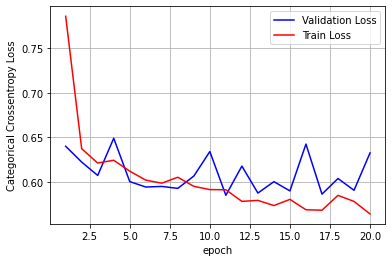

In [0]:
plt_dynamic(20)
pred=model.predict([test_input_ids_submisson, test_input_masks_submisson, test_segment_ids_submisson])
f1_score(original['target'], pred.round())

In [0]:
in_id = Input(shape=(max_seq_length,), name="input_ids")
in_mask = Input(shape=(max_seq_length,), name="input_masks")
in_segment = Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]
bert_output = BertLayer(n_fine_tune_layers=6)(bert_inputs)
dense = Dense(256, activation='relu')(bert_output)
pred = Dense(1, activation='sigmoid')(dense)
    
model = Model(inputs=bert_inputs, outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[f1])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 140)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        ((None, 140), 768)   110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
in_id = Input(shape=(max_seq_length,), name="input_ids")
in_mask = Input(shape=(max_seq_length,), name="input_masks")
in_segment = Input(shape=(max_seq_length,), name="segment_ids")
bert_inputs = [in_id, in_mask, in_segment]
bert_output = BertLayer(n_fine_tune_layers=2)(bert_inputs)
dense = Dense(256, activation='relu')(bert_output)
pred = Dense(1, activation='sigmoid')(dense)
    
model = Model(inputs=bert_inputs, outputs=pred)

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=[f1])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 140)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 140)          0                                            
__________________________________________________________________________________________________
bert_layer_6 (BertLayer)        ((None, 140), 768)   110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [0]:
history=model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=35,
    batch_size=128 )

Train on 6090 samples, validate on 1523 samples
Epoch 1/35
6090/6090 [==============================] - 47s 8ms/step - loss: 0.9945 - f1: 0.3300 - val_loss: 0.8018 - val_f1: 0.0000e+00
Epoch 2/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.7808 - f1: 0.3534 - val_loss: 1.0129 - val_f1: 0.6173
Epoch 3/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6845 - f1: 0.4443 - val_loss: 0.6210 - val_f1: 0.5919
Epoch 4/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6427 - f1: 0.4983 - val_loss: 0.6197 - val_f1: 0.5991
Epoch 5/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6374 - f1: 0.5365 - val_loss: 1.3004 - val_f1: 0.0000e+00
Epoch 6/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6509 - f1: 0.4945 - val_loss: 0.6512 - val_f1: 0.1562
Epoch 7/35
6090/6090 [==============================] - 39s 6ms/step - loss: 0.6153 - f1: 0.5432 - val_loss: 0.6148 - val_f1: 0.6518
Epoch 8/35
60

0.1819330385344283

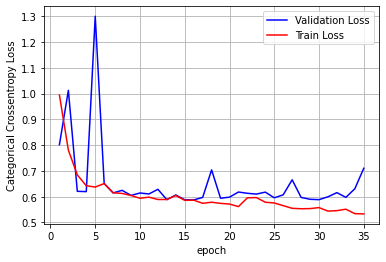

In [0]:
plt_dynamic(35)
pred=model.predict([test_input_ids_submisson, test_input_masks_submisson, test_segment_ids_submisson])
f1_score(original['target'], pred.round())

# Glove, Positional Encoding and Attention

In [0]:
def words(text):
    return re.findall(r'\w+', text.lower())
def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)
def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or [word])
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)
def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])


In [0]:
# modified version of 
# https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings
# https://www.kaggle.com/danofer/different-embeddings-with-attention-fork
# https://www.kaggle.com/shujian/different-embeddings-with-attention-fork-fork
def load_glove(word_dict, lemma_dict):
    EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    print(unknown_vector[:5])
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words 


def load_fasttext(word_dict, lemma_dict):
    EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/paragram_300_sl999.txt'
    def get_coefs(word,*arr): 
      return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)
    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    print(unknown_vector[:5])
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words 


def load_para(word_dict, lemma_dict):
    EMBEDDING_FILE = '/content/drive/My Drive/Colab Notebooks/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)
    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    print(unknown_vector[:5])
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words 


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train.csv').fillna(' ')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test.csv').fillna(' ')
original=pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP Original.csv")


In [0]:
train_text = train['text']
test_text = test['text']
text_list = pd.concat([train_text, test_text])

In [0]:
# https://www.kaggle.com/cpmpml/spell-checker-using-word2vec
import gensim
spell_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/wiki-news-300d-1M.vec')
words = spell_model.index2word
w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
start_time = time.time()
print("Spacy NLP ...")
nlp = spacy.load('/content/drive/My Drive/Colab Notebooks/en_core_web_lg-2.1.0/en_core_web_lg/en_core_web_lg-2.1.0', disable=['parser','ner','tagger'])
nlp.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
word_dict = {}
word_index = 1
lemma_dict = {}
docs = nlp.pipe(text_list, n_threads = 2)
word_sequences = []
for doc in tqdm(docs):
    word_seq = []
    for token in doc:
        if (token.text not in word_dict) and (token.pos_ is not "PUNCT"):
            word_dict[token.text] = word_index
            word_index += 1
            lemma_dict[token.text] = token.lemma_
        if token.pos_ is not "PUNCT":
            word_seq.append(word_dict[token.text])
    word_sequences.append(word_seq)
del docs
gc.collect()
# train_word_sequences = word_sequences[:num_train_data]
# test_word_sequences = word_sequences[num_train_data:]
print("--- %s seconds ---" % (time.time() - start_time))

Spacy NLP ...


10876it [00:03, 3379.34it/s]


--- 29.566516876220703 seconds ---


In [0]:
y = train['target'].values
num_train_data = y.shape[0]

In [0]:
train_word_sequences = word_sequences[:num_train_data]
test_word_sequences = word_sequences[num_train_data:]

In [0]:
# hyperparameters
max_length = 140
embedding_size = 600
learning_rate = 0.001
batch_size = 256
num_epoch = 4

train_word_sequences = pad_sequences(train_word_sequences, maxlen=max_length, padding='post')
test_word_sequences = pad_sequences(test_word_sequences, maxlen=max_length, padding='post')
print(train_word_sequences[:1])
print(test_word_sequences[:1])
pred_prob = np.zeros((len(test_word_sequences),), dtype=np.float32)

[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[[  46  762   57 3545  154  155    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0 

In [0]:
embedding_matrix_fasttext, nb_words = load_fasttext(word_dict, lemma_dict)

  4%|▎         | 1228/34503 [00:00<00:02, 12269.39it/s]

[-1. -1. -1. -1. -1.]


100%|██████████| 34503/34503 [00:06<00:00, 5033.16it/s]


In [0]:
embedding_matrix_glove, nb_words = load_glove(word_dict, lemma_dict)

  3%|▎         | 1186/34503 [00:00<00:02, 11856.62it/s]

[-1. -1. -1. -1. -1.]


100%|██████████| 34503/34503 [00:06<00:00, 5346.85it/s]


In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [0]:
def build_model(embedding_matrix, nb_words, embedding_size=300):
    inp = Input(shape=(max_length,))
    x = Embedding(nb_words, embedding_size, weights=[embedding_matrix], trainable=False)(inp)
                    
    # prob = Position_Embedding()(x)
    # prob = AttentionWithContext()(prob)
    # prob = GlobalMaxPool1D()(prob)      
    prob = Position_Embedding()(BatchNormalization()(x))
    # prob = Attention_block(prob, 4, 64, 1024)
    prob = GlobalMaxPool1D()(prob)
    # x = SpatialDropout1D(0.3)(x)
    x1 = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
    x2 = Bidirectional(CuDNNGRU(128, return_sequences=True))(x1)
    max_pool1 = AttentionWithContext()(x1)
    max_pool2 = AttentionWithContext()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=inp, outputs=predictions)
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[f1])
    return model

In [0]:

model = build_model(embedding_matrix_glove, nb_words, embedding_size=300)
history=model.fit(train_word_sequences, y, batch_size=batch_size, epochs=20, validation_split=0.2, verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
 - 10s - loss: 0.5435 - f1: 0.5946 - val_loss: 0.4216 - val_f1: 0.7557
Epoch 2/20
 - 3s - loss: 0.4245 - f1: 0.7565 - val_loss: 0.4235 - val_f1: 0.7780
Epoch 3/20
 - 3s - loss: 0.3910 - f1: 0.7890 - val_loss: 0.4133 - val_f1: 0.7677
Epoch 4/20
 - 3s - loss: 0.3609 - f1: 0.8067 - val_loss: 0.4226 - val_f1: 0.7736
Epoch 5/20
 - 3s - loss: 0.3470 - f1: 0.8167 - val_loss: 0.4380 - val_f1: 0.7434
Epoch 6/20
 - 3s - loss: 0.3184 - f1: 0.8400 - val_loss: 0.4505 - val_f1: 0.7760
Epoch 7/20
 - 3s - loss: 0.3058 - f1: 0.8469 - val_loss: 0.4465 - val_f1: 0.7576
Epoch 8/20
 - 3s - loss: 0.2743 - f1: 0.8637 - val_loss: 0.4781 - val_f1: 0.7553
Epoch 9/20
 - 3s - loss: 0.2487 - f1: 0.8831 - val_loss: 0.4974 - val_f1: 0.7469
Epoch 10/20
 - 3s - loss: 0.2320 - f1: 0.8903 - val_loss: 0.5175 - val_f1: 0.7408
Epoch 11/20
 - 3s - loss: 0.2003 - f1: 0.9052 - val_loss: 0.5854 - val_f1: 0.7304
Epoch 12/20
 - 3s - loss: 0.1869 - f1: 0.9145 - val_loss: 

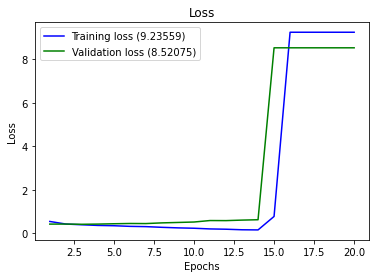

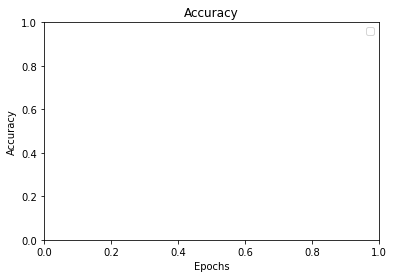

In [0]:
plot_history(history)

# RoBERTa
https://huggingface.co/transformers/pretrained_models.html

https://medium.com/swlh/simplerepresentations-bert-roberta-xlm-xlnet-and-distilbert-features-for-any-nlp-task-468b5ceb6f0e

https://github.com/AliOsm/simplerepresentations/blob/master/examples/text_classification_example.ipynb


In [0]:
import numpy as np
from keras.utils import Sequence

from keras.layers.normalization import BatchNormalization
class DataGenerator(Sequence):
    def __init__(self, representation_model, sentences, labels, batch_size, token_level=True):
        self.representation_model = representation_model
        self.sentences = sentences
        self.labels = labels
        self.batch_size = batch_size
        self.token_level = token_level

    def __len__(self):
        return int(np.ceil(len(self.sentences) / float(self.batch_size)))

    def __getitem__(self, idx):
        sentences_batch = np.array(self.sentences[idx * self.batch_size:(idx + 1) * self.batch_size])
        labels_batch = np.array(self.labels[idx * self.batch_size:(idx + 1) * self.batch_size])

        sentences_sen_batch, sentences_tok_batch = self.representation_model(sentences_batch)

        if self.token_level:
            sentences_batch = sentences_tok_batch
        else:
            sentences_batch = sentences_sen_batch

        return sentences_batch, np.array(labels_batch)

In [0]:
class Self_Attention(Layer):
    def __init__(self, head_num, head_size, **kwargs):
        self.head_size = head_size
        self.sqrt_head_size = math.sqrt(head_size)
        self.head_num = head_num
        self.output_units = head_size * head_num
        self.supports_masking = True
        super(Self_Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        self.kernal = self.add_weight('kernal', (self.head_num, 3, self.d_model, self.head_size),
                                      initializer = 'glorot_uniform')
        super(Self_Attention, self).build(input_shape)
        self.built = True
    def call(self, inputs, mask = None):
        w = K.dot(inputs, self.kernal)
        w = K.permute_dimensions(w, [3, 2, 0, 1, 4])
        Head = K.batch_dot(w[0], K.permute_dimensions(w[1], [0, 1, 3, 2]))
        if mask is not None:
            new_mask = K.expand_dims(mask, -1)
            new_mask = K.batch_dot(new_mask, K.permute_dimensions(new_mask, [0, 2, 1]))
            new_mask = K.expand_dims(new_mask, 0)
            Head -= 1e8 * (K.ones_like(Head) - new_mask)
        Head = K.softmax(Head)
        Head = K.batch_dot(Head, w[2])
        Head = K.permute_dimensions(Head, [1, 2, 3, 0])
        return K.reshape(Head, (-1, K.shape(Head)[1],self.output_units))
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_units)
    def compute_mask(self, inputs, mask = None):
        pass

In [0]:
class Position_Embedding(Layer):
    def __init__(self, **kwargs):
        self.supports_masking = True
        super(Position_Embedding, self).__init__(**kwargs)
    def build(self, input_shape):
        self.depth = input_shape[1]
        self.d_model = input_shape[2]
        super(Position_Embedding, self).build(input_shape)
        self.built = True
    def call(self, inputs):
        pos_emb = np.zeros([1, self.depth, self.d_model])
        p = np.zeros([self.d_model], dtype = 'int32')
        for i in range(self.d_model):
            p[i] = math.pow(10000, (i - 1) / self.d_model) if i%2 else math.pow(10000, i / self.d_model)
        for i in range(self.depth):
            for j in range(self.d_model):
                pos_emb[0][i][j] = math.cos(i / p[j]) if j%2 else math.sin(i / p[j])
        return inputs + tf.Variable(np.asarray(pos_emb, dtype = 'float32'), trainable = False)
    def compute_mask(self, inputs, mask = None):
        pass

In [0]:
def Attention_block(inputs, head_num, head_size, hidden_units):
    s = Self_Attention(head_num, head_size)(inputs)
    s = BatchNormalization()(Add()([s, inputs]))
    output = Dense(hidden_units, activation = 'relu')(s)
    output = Dense(int(inputs.shape[-1]))(output)
    return BatchNormalization()(Add()([s, output]))

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
from simplerepresentations import RepresentationModel

model_type = 'roberta'
model_name = 'roberta-base'

representation_model = RepresentationModel(
    model_type=model_type,
    model_name=model_name,
    batch_size=128,
    max_seq_length=128, # truncate sentences to be less than or equal to 128 tokens
    combination_method='sum', # sum the last `last_hidden_to_use` hidden states
    last_hidden_to_use=1, # use the last 1 hidden states to build tokens representations
    verbose=0
)

In [0]:
all_sentences_representations, all_tokens_representations = representation_model(['Simple Representations!'])

print(all_sentences_representations.shape) # (1, 768)
print(all_tokens_representations.shape) # (1, 128, 768)
print(all_sentences_representations[0].shape) # (768,)
print(all_tokens_representations[0].shape) # (128, 768)

(1, 768)
(1, 128, 768)
(768,)
(128, 768)


In [0]:
# train_text, test_text, train_label, test_label 

In [0]:
train_tok_generator = DataGenerator(representation_model, train_text, train_label, 128)
val_tok_generator = DataGenerator(representation_model, test_text, test_label, 128)
test_tok_generator = DataGenerator(representation_model, test['text'], original['target'], 128)

In [0]:
from keras.models import Input, Model
from keras.layers import Dropout, Dense, LSTM, Bidirectional
from keras.optimizers import Adam

model_input = Input(shape=(128, len(representation_model(['test'])[0][0])))

model = Bidirectional(LSTM(units=128,dropout=0.3, return_sequences=True))(model_input)
model = Bidirectional(LSTM(units=128,dropout=0.3, return_sequences=False))(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.3)(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(model_input, model_output)

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 768)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128, 256)          918528    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,345,793
Trainable params: 1,345,793
Non-trainable params: 0
_________________________________________________

In [0]:
history=model.fit_generator(train_tok_generator,validation_data=val_tok_generator, epochs=10)

Epoch 1/10
48/48 [==============================] - 169s 4s/step - loss: 0.5474 - f1: 0.6284 - val_loss: 0.4209 - val_f1: 0.7832
Epoch 2/10
48/48 [==============================] - 156s 3s/step - loss: 0.4247 - f1: 0.7666 - val_loss: 0.3960 - val_f1: 0.8043
Epoch 3/10
48/48 [==============================] - 158s 3s/step - loss: 0.4041 - f1: 0.7762 - val_loss: 0.3870 - val_f1: 0.8049
Epoch 4/10
48/48 [==============================] - 158s 3s/step - loss: 0.3983 - f1: 0.7853 - val_loss: 0.4204 - val_f1: 0.8134
Epoch 5/10
48/48 [==============================] - 158s 3s/step - loss: 0.3888 - f1: 0.7929 - val_loss: 0.3870 - val_f1: 0.8138
Epoch 6/10
48/48 [==============================] - 158s 3s/step - loss: 0.3736 - f1: 0.8007 - val_loss: 0.3810 - val_f1: 0.8143
Epoch 7/10
48/48 [==============================] - 160s 3s/step - loss: 0.3624 - f1: 0.8055 - val_loss: 0.4061 - val_f1: 0.7970
Epoch 8/10
48/48 [==============================] - 160s 3s/step - loss: 0.3589 - f1: 0.8106 - va

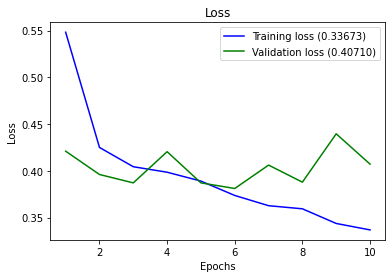

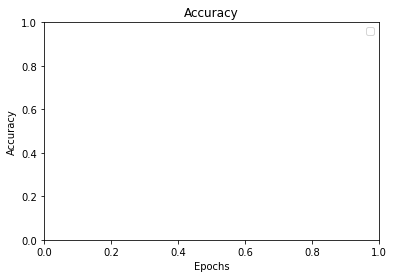

In [0]:
plot_history(history)

In [0]:
print(model.evaluate_generator(test_tok_generator))

[0.4287386970343927, 0.7640821193574654]


In [0]:

pred=model.predict(test_tok_generator)
f1_score(original['target'], pred.round())

0.7914674512688489

In [0]:
from keras.models import Input, Model
from keras.layers import Dropout, Dense, LSTM, Bidirectional
from keras.optimizers import Adam

model_input = Input(shape=(128, len(representation_model(['test'])[0][0])))

model = Bidirectional(LSTM(units=128,dropout=0.3, return_sequences=True))(model_input)
model = Bidirectional(LSTM(units=128,dropout=0.3, return_sequences=True))(model)
model=AttentionWithContext()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.3)(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(model_input, model_output)

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[f1])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 128, 768)          0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128, 256)          918528    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 128, 256)          394240    
_________________________________________________________________
attention_with_context_5 (At (None, 256)               66048     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129 

Epoch 1/20
48/48 [==============================] - 176s 4s/step - loss: 0.5022 - f1: 0.6978 - val_loss: 0.4327 - val_f1: 0.7966
Epoch 2/20
48/48 [==============================] - 159s 3s/step - loss: 0.4090 - f1: 0.7720 - val_loss: 0.3872 - val_f1: 0.7777
Epoch 3/20
19/48 [==========>...................] - ETA: 1:45 - loss: 0.3775 - f1: 0.8019

KeyboardInterrupt: ignored

[0.3967624303938748, 0.7697905544813812]


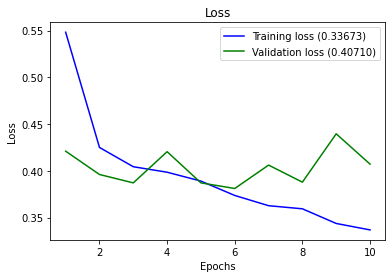

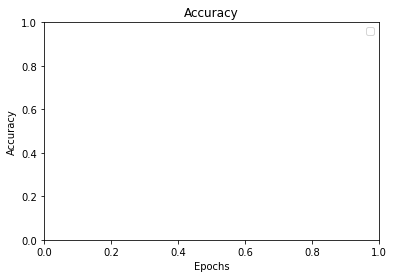

In [0]:
print(model.evaluate_generator(test_tok_generator))
plot_history(history)

In [0]:
def build_model(embedding_matrix, nb_words, embedding_size=300):
    inp = Input(shape=(max_length,))
    x = Embedding(nb_words, embedding_size, weights=[embedding_matrix], trainable=False)(inp)
                    
    # prob = Position_Embedding()(x)
    # prob = AttentionWithContext()(prob)
    # prob = GlobalMaxPool1D()(prob)      
    prob = Position_Embedding()(x)
    # prob = Attention_block(prob, 4, 64, 1024)
    prob = GlobalMaxPool1D()(prob)
    # x = SpatialDropout1D(0.3)(x)
    x1 = Bidirectional(CuDNNLSTM(256, return_sequences=True))(BatchNormalization()(x))
    x2 = Bidirectional(CuDNNGRU(128, return_sequences=True))(BatchNormalization()(x1))
    max_pool1 = AttentionWithContext()(x1)
    max_pool2 = AttentionWithContext()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=inp, outputs=predictions)
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[f1])
    return model

In [0]:

model = build_model(embedding_matrix_glove, nb_words, embedding_size=300)
history=model.fit(train_word_sequences, y, batch_size=batch_size, epochs=20, validation_split=0.2, verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
 - 12s - loss: 0.5999 - f1: 0.5184 - val_loss: 0.5386 - val_f1: 0.6805
Epoch 2/20
 - 4s - loss: 0.4433 - f1: 0.7419 - val_loss: 0.4894 - val_f1: 0.7702
Epoch 3/20
 - 4s - loss: 0.3367 - f1: 0.8259 - val_loss: 0.4468 - val_f1: 0.7571
Epoch 4/20
 - 4s - loss: 0.2321 - f1: 0.8947 - val_loss: 0.4644 - val_f1: 0.7600
Epoch 5/20
 - 4s - loss: 0.1468 - f1: 0.9441 - val_loss: 0.6254 - val_f1: 0.6975
Epoch 6/20
 - 4s - loss: 0.1113 - f1: 0.9542 - val_loss: 0.6531 - val_f1: 0.7572
Epoch 7/20
 - 4s - loss: 0.0831 - f1: 0.9656 - val_loss: 0.6830 - val_f1: 0.7468
Epoch 8/20
 - 4s - loss: 0.0795 - f1: 0.9619 - val_loss: 0.7570 - val_f1: 0.7115
Epoch 9/20
 - 4s - loss: 0.0690 - f1: 0.9695 - val_loss: 0.8223 - val_f1: 0.7339
Epoch 10/20
 - 4s - loss: 0.0540 - f1: 0.9736 - val_loss: 0.8059 - val_f1: 0.7547
Epoch 11/20
 - 4s - loss: 0.0639 - f1: 0.9702 - val_loss: 0.7547 - val_f1: 0.7561
Epoch 12/20
 - 4s - loss: 0.0474 - f1: 0.9757 - val_loss: 

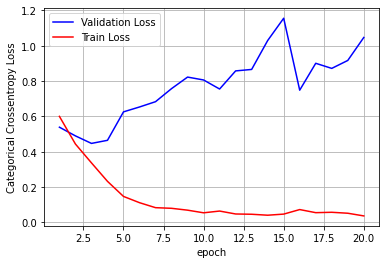

In [0]:
plt_dynamic(20)

In [0]:
def build_model(embedding_matrix, nb_words, embedding_size=300):
    inp = Input(shape=(max_length,))
    x = Embedding(nb_words, embedding_size, weights=[embedding_matrix], trainable=False)(inp)
                    
    # prob = Position_Embedding()(x)
    # prob = AttentionWithContext()(prob)
    # prob = GlobalMaxPool1D()(prob)      
    prob = Position_Embedding()(x)
    # prob = Attention_block(prob, 4, 64, 1024)
    # prob = GlobalMaxPool1D()(prob)
    # x = SpatialDropout1D(0.3)(x)
    x1 = Bidirectional(CuDNNLSTM(256, return_sequences=True))(BatchNormalization()(x))
    x2 = Bidirectional(CuDNNGRU(128, return_sequences=True))(BatchNormalization()(x1))
    max_pool1 = AttentionWithContext()(x1)
    max_pool2 = AttentionWithContext()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=inp, outputs=predictions)
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[f1])
    return model

In [0]:

model = build_model(embedding_matrix_glove, nb_words, embedding_size=300)
history=model.fit(train_word_sequences, y, batch_size=batch_size, epochs=20, validation_split=0.2, verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
 - 12s - loss: 0.5118 - f1: 0.6813 - val_loss: 0.4592 - val_f1: 0.7818
Epoch 2/20
 - 4s - loss: 0.3135 - f1: 0.8404 - val_loss: 0.4177 - val_f1: 0.7855
Epoch 3/20
 - 4s - loss: 0.1939 - f1: 0.9162 - val_loss: 0.4570 - val_f1: 0.7690
Epoch 4/20
 - 4s - loss: 0.1290 - f1: 0.9506 - val_loss: 0.5013 - val_f1: 0.7754
Epoch 5/20
 - 4s - loss: 0.0969 - f1: 0.9591 - val_loss: 0.5600 - val_f1: 0.7812
Epoch 6/20
 - 4s - loss: 0.0964 - f1: 0.9600 - val_loss: 0.5714 - val_f1: 0.7670
Epoch 7/20
 - 4s - loss: 0.0933 - f1: 0.9601 - val_loss: 0.5795 - val_f1: 0.7745
Epoch 8/20
 - 4s - loss: 0.0807 - f1: 0.9678 - val_loss: 0.6085 - val_f1: 0.7690
Epoch 9/20
 - 4s - loss: 0.0648 - f1: 0.9709 - val_loss: 0.6837 - val_f1: 0.7616
Epoch 10/20
 - 4s - loss: 0.0607 - f1: 0.9705 - val_loss: 0.6974 - val_f1: 0.7606
Epoch 11/20
 - 4s - loss: 0.0660 - f1: 0.9701 - val_loss: 0.6790 - val_f1: 0.7687
Epoch 12/20
 - 4s - loss: 0.0684 - f1: 0.9679 - val_loss: 

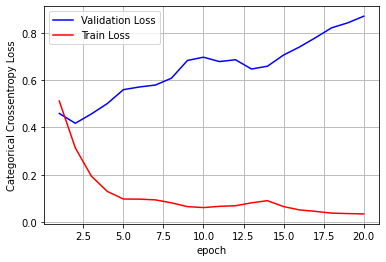

In [0]:
plt_dynamic(20)

In [0]:
def build_model(embedding_matrix, nb_words, embedding_size=300):
    inp = Input(shape=(max_length,))
    x = Embedding(nb_words, embedding_size, weights=[embedding_matrix], trainable=False)(inp)
                    
    # prob = Position_Embedding()(x)
    # prob = AttentionWithContext()(prob)
    # prob = GlobalMaxPool1D()(prob)      
    prob = Position_Embedding()(x)
    # prob = Attention_block(prob, 4, 64, 1024)
    # prob = GlobalMaxPool1D()(prob)
    # x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)
    
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(BatchNormalization()(x))
    max_pool1 = AttentionWithContext()(x)
    # max_pool2 = AttentionWithContext()(x2)
    # conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(max_pool1)
    model = Model(inputs=inp, outputs=predictions)
    adam = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[f1, 'accuracy'])
    return model

In [0]:

model = build_model(embedding_matrix_glove, nb_words, embedding_size=300)
history=model.fit(train_word_sequences, y, batch_size=batch_size, epochs=150, validation_split=0.2, verbose=2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/150
 - 13s - loss: 0.6666 - f1: 0.3411 - acc: 0.5870 - val_loss: 0.6026 - val_f1: 0.7170 - val_acc: 0.7400
Epoch 2/150
 - 3s - loss: 0.4893 - f1: 0.7204 - acc: 0.7813 - val_loss: 0.6075 - val_f1: 0.7379 - val_acc: 0.7479
Epoch 3/150
 - 3s - loss: 0.4288 - f1: 0.7627 - acc: 0.8133 - val_loss: 0.5237 - val_f1: 0.7672 - val_acc: 0.7787
Epoch 4/150
 - 3s - loss: 0.4097 - f1: 0.7772 - acc: 0.8261 - val_loss: 0.4891 - val_f1: 0.7638 - val_acc: 0.7761
Epoch 5/150
 - 3s - loss: 0.4002 - f1: 0.7835 - acc: 0.8305 - val_loss: 0.4355 - val_f1: 0.7810 - val_acc: 0.8102
Epoch 6/150
 - 3s - loss: 0.3639 - f1: 0.8039 - acc: 0.8463 - val_loss: 0.4641 - val_f1: 0.7497 - val_acc: 0.8043
Epoch 7/150
 - 3s - loss: 0.3325 - f1: 0.8236 - acc: 0.8611 - val_loss: 0.4428 - val_f1: 0.7418 - val_acc: 0.8056
Epoch 8/150
 - 3s - loss: 0.3023 - f1: 0.8453 - acc: 0.8775 - val_loss: 0.4544 - val_f1: 0.7393 - val_acc: 0.8011
Epoch 9/150
 - 3s - loss: 0.2654 - f1: 

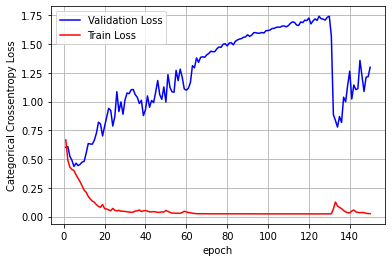

In [0]:
plt_dynamic(150)
# print(model.prdeict(test_tok_generator))